# Data Cleaning
Brandon Shellenberger

In [ ]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

## Making Global Variables

In [ ]:
PROJECT_ROOT = pathlib.Path().parent.parent
DATA_FOLDER = PROJECT_ROOT.joinpath('data')
HOUSE_PRICING_DATA = DATA_FOLDER.joinpath('kaggle_house_pricing.csv')

### Handling with NaN, Duplicates, unrelated columns, renaming columns

## Cleaning Kaggle Data

In [109]:
kaggle_ml = pd.read_csv(HOUSE_PRICING_DATA)
print(kaggle_ml.shape)
print(kaggle_ml.head(3))
print(kaggle_ml.dtypes)
print(kaggle_ml.describe())

# Checked for null values, there are none
print(kaggle_ml.isnull().sum())

# Checked for duplicates, there are none
print(kaggle_ml.duplicated().sum())

# All columns are lowercase

(545, 13)
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object
              price     

### Scatter plots of numerical data

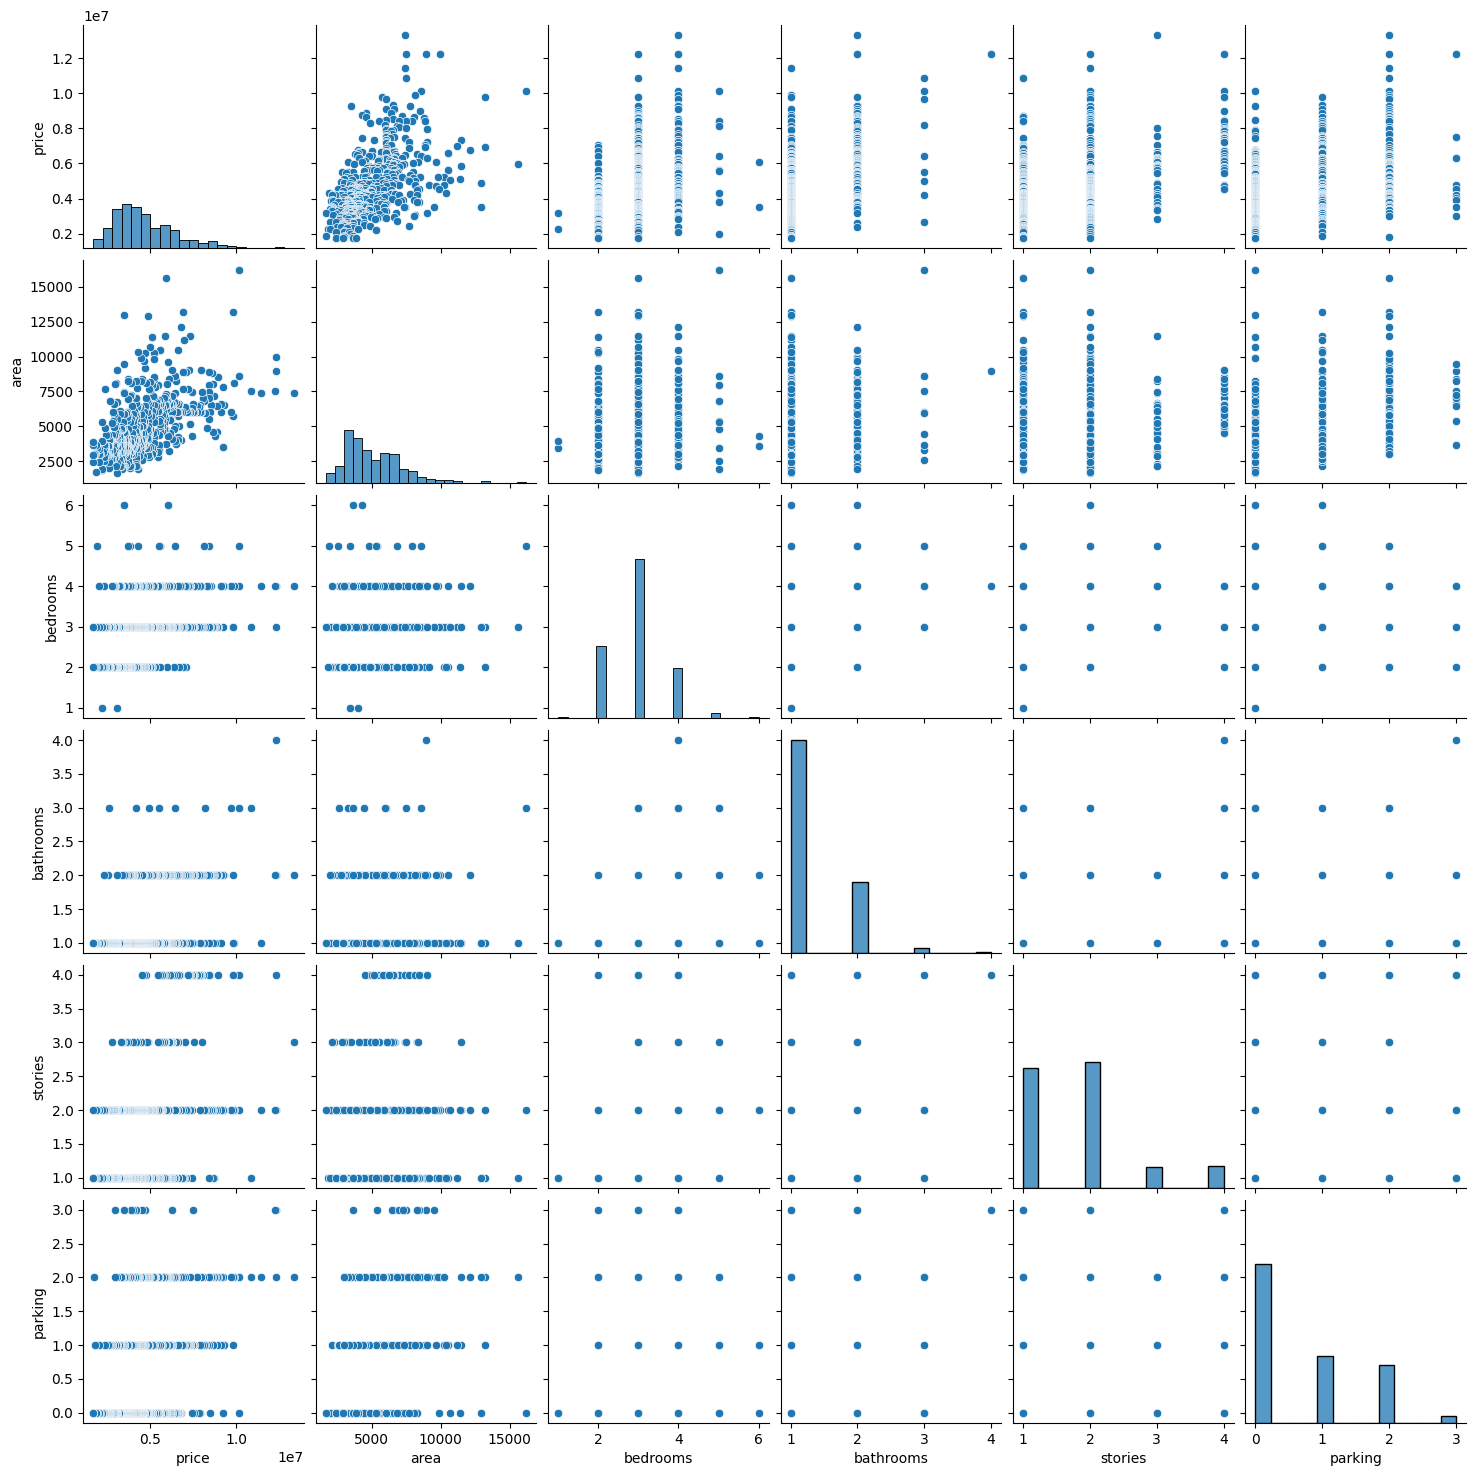

In [33]:
sns.pairplot(kaggle_ml)

### Frequencies of categorical data

mainroad
yes    468
no      77
Name: count, dtype: int64


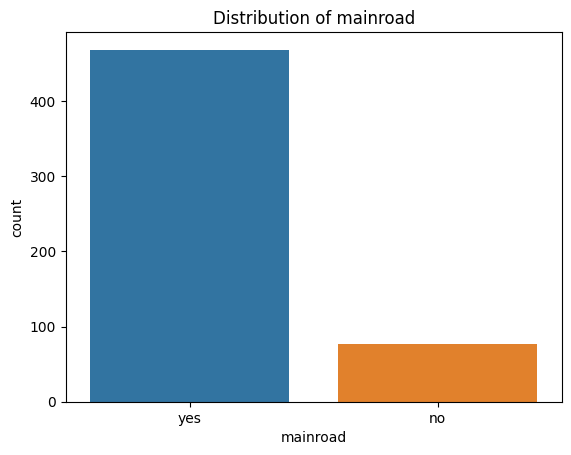

guestroom
no     448
yes     97
Name: count, dtype: int64


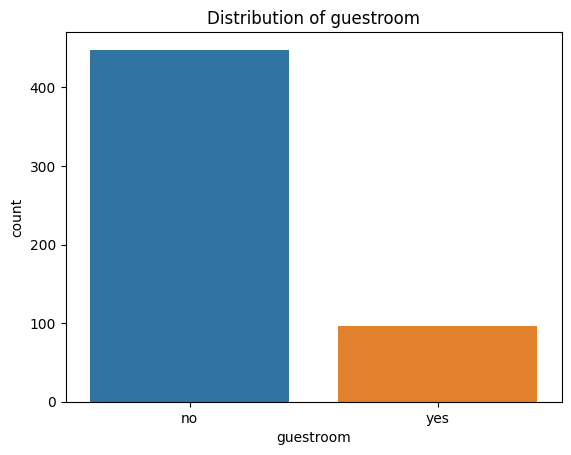

basement
no     354
yes    191
Name: count, dtype: int64


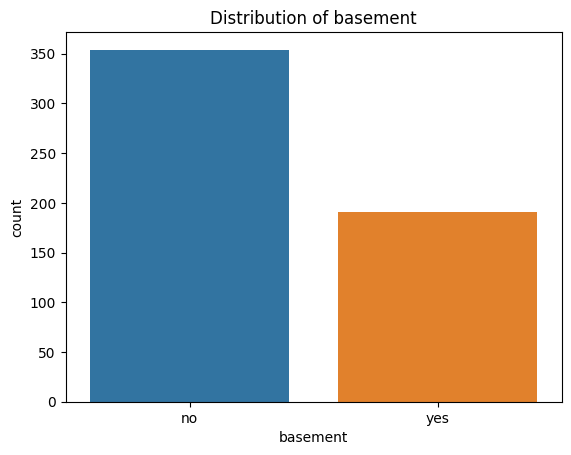

hotwaterheating
no     520
yes     25
Name: count, dtype: int64


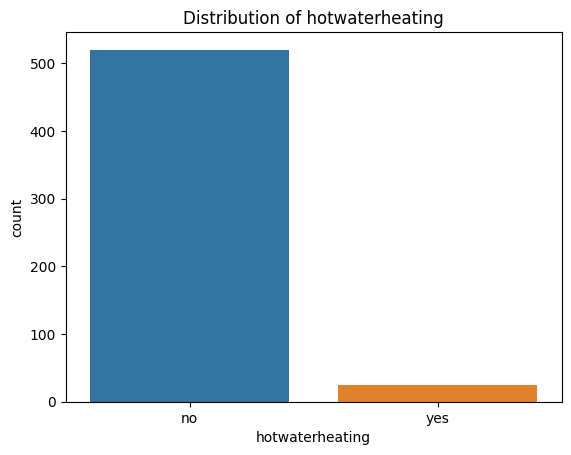

airconditioning
no     373
yes    172
Name: count, dtype: int64


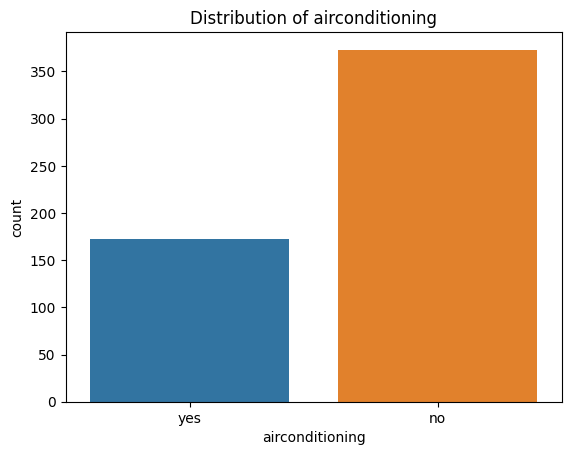

prefarea
no     417
yes    128
Name: count, dtype: int64


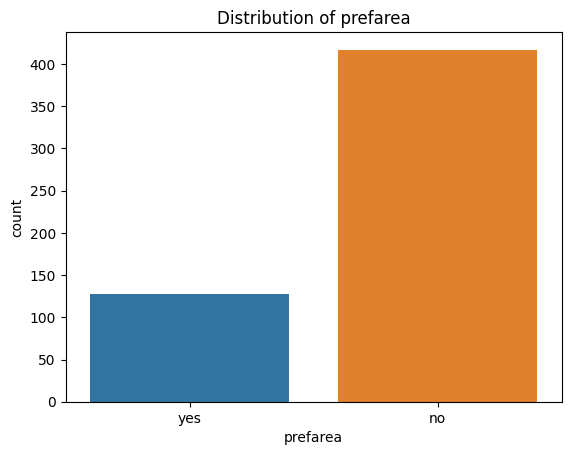

furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64


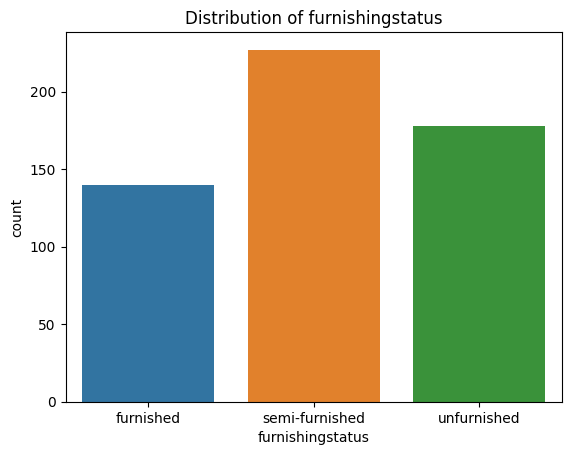

In [27]:
# Frequency chart for numerical data
# kaggle_ml.hist(bins=30)

# Frequency chart for categorical data
# # Using this to determine variables for regression
for col in kaggle_ml.select_dtypes(include=['object', 'category']).columns:
    print(kaggle_ml[col].value_counts())
    # Display count chart
    sns.countplot(data=kaggle_ml, x=col, hue=col)
    plt.title(f'Distribution of {col}')
    plt.show()

# Variables to use
# Bedrooms, Bathrooms, Stories, Basement, Air Conditioning, Furnishing

### Clearing unwanted data and Hot Encoding Categorica data

In [ ]:
kaggle_dropped_col = kaggle_ml.drop(columns=['mainroad', 'guestroom', 'hotwaterheating', 'airconditioning', 'furnishingstatus', 'prefarea'])

kaggle_dropped_col.dropna()

# One-Hot-Encoding
# Encoding basement as 2 columns (yes and not)
kaggle_hot_encoded = pd.get_dummies(kaggle_dropped_col, columns=['basement'], dtype=int)
print(kaggle_hot_encoded.head(5))

      price  area  bedrooms  bathrooms  stories  parking  basement_no  \
0  13300000  7420         4          2        3        2            1   
1  12250000  8960         4          4        4        3            1   
2  12250000  9960         3          2        2        2            0   
3  12215000  7500         4          2        2        3            0   
4  11410000  7420         4          1        2        2            0   

   basement_yes  
0             0  
1             0  
2             1  
3             1  
4             1  


## EDA

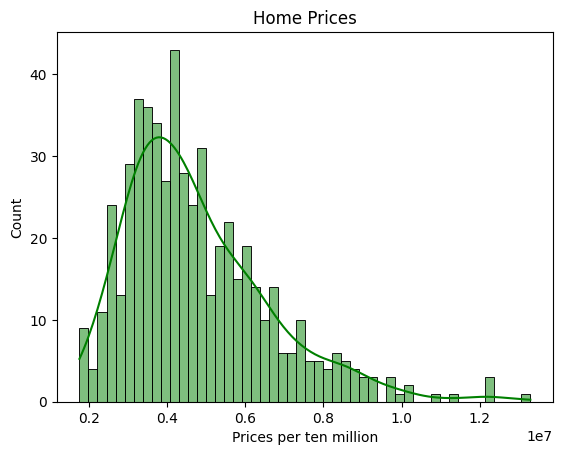

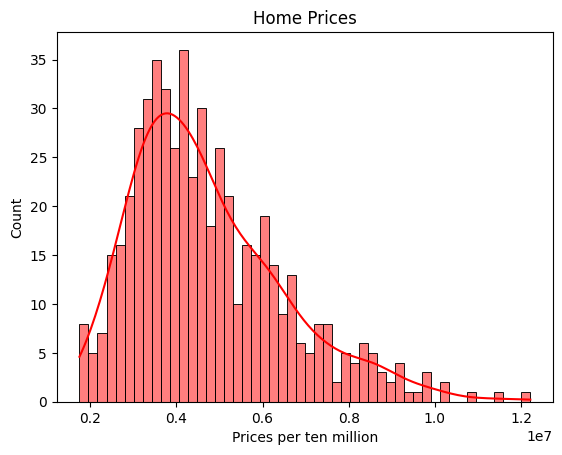

In [ ]:
sns.histplot(kaggle_hot_encoded, x='price', bins=50, color='green', kde=True)
plt.xlabel("Prices per ten million")
plt.title("Home Prices with Outliers")
plt.show()

# Inner Quartile Range outlier detection
q1 = kaggle_hot_encoded['price'].quantile(0.25)
q3 = kaggle_hot_encoded['price'].quantile(0.75)
iqr = q3 - q1
outliers_iqr = kaggle_hot_encoded[(kaggle_hot_encoded['price'] < (q1 - 1.5 * iqr)) | (kaggle_hot_encoded['price'] > (q3 + 1.5 * iqr))]
# print(outliers_iqr.shape)

# Z-scores outlier detection
z_scores = np.abs(stats.zscore(kaggle_hot_encoded['price']))
outliers_z_up = kaggle_hot_encoded[z_scores > 4]
outliers_z_low = kaggle_hot_encoded[z_scores < -4]
outliers_z = pd.concat([outliers_z_up, outliers_z_low])
# print(outliers_z.shape)

# Intersection of both outlier lists
total_outliers = outliers_iqr[outliers_iqr.isin(outliers_z)].dropna()

kaggle_no_outliers = kaggle_hot_encoded[~kaggle_hot_encoded.isin(total_outliers)].dropna().reset_index().drop(columns='index')
# print(kaggle_no_outliers.corr())

kaggle_df = kaggle_no_outliers

sns.histplot(kaggle_df, x='price', bins=50, color='red', kde=True)
plt.xlabel("Prices per ten million")
plt.title("Home Prices without Ooutliers")
plt.show()

file_path_1 = DATA_FOLDER / 'kaggle_cleaned.csv'
kaggle_df.to_csv(file_path_1, index=False)